<a href="https://colab.research.google.com/github/thenaivekid/Vision-Transformer-From-Scratch/blob/main/Implementing_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Todo
## do it in mnist digits dataset
- [x] load dataset
- [x] implement paper in code.
- [ ] train from scratch for a few epochs supervised(training)
- [ ] viz loss and gradients to see if the training is approaching a minima or not
- [ ] viz learned positional embedding
- [ ] viz attn map for few images
- [ ] load weights from pretrained
- [ ] finetune for 2 class classification. (2 class plus 1 unknown)
- [ ] viz clustering effect of vit in 2 classes
- [ ] do everything by doing self supervised training. mae, jepa(optional)
- [ ] distill this in smaller model
- [ ] use synthetic data to make it better



# Loading MNIST digit dataset

https://huggingface.co/datasets/ylecun/mnist

In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

to_tensor = transforms.ToTensor()
def transform(batch):
  batch["image"] = [(to_tensor(img)) for img in batch["image"]]
  return batch

ds.set_transform(transform) # it does the transformation when loading the data later during training and testing
# ds.map(transform, batched = True)# it transforms the whole dataset upfront. takes too long

In [ ]:
split_ds = ds["train"].train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds = split_ds["train"]
val_ds = split_ds["test"]
test_ds = ds["test"]

In [ ]:
one_data = next(iter(ds["train"]))
print(one_data["label"])
print(one_data["image"].shape)
print(type(one_data["image"]))


5
torch.Size([1, 28, 28])
<class 'torch.Tensor'>


In [ ]:
BATCH_SIZE = 64

In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [ ]:
one_image = next(iter(train_loader))["image"][0]
print(one_image.shape)

torch.Size([1, 28, 28])


# Vision Transformer implementation
src: http://arxiv.org/abs/2010.11929
##An Image is Worth 16x16 Words
https://github.com/google-research/vision_transformer

In [ ]:
P = 4 #patch size
C = 1
H = 28
W = 28
N = int(H * W / P**2)
print(f"Number of patches: {N}, patch size: {P}")

Number of patches: 49, patch size: 4


In [ ]:
from torch import nn

class MakePatches(nn.Module):
  def __init__(self, patch_size=P):
    super().__init__()
    self.patch_size = patch_size
    self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    b, c, h, w = x.shape
    x = self.unfold(x)#B,(c*p*p), n.   n = no .f patches
    # x = x.view(b, c, self.patch_size, self.patch_size, -1).permute(0, 4, 1, 2, 3)#b,n,c,p,p
    x = x.view(b, -1, C*P*P)
    return x

  def viz(self, x):
    b, c, h, w = x.shape
    x = self.unfold(x)#B,(c*p*p), n.   n = no .f patches
    x = x.view(b, c, self.patch_size, self.patch_size, -1).permute(0, 4, 1, 2, 3)#b,n,c,p,p
    return x



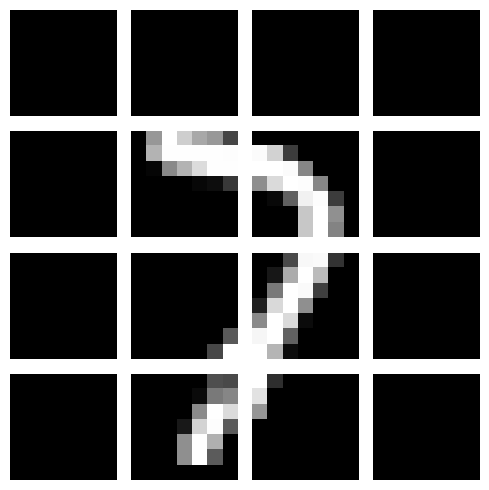

In [ ]:
import matplotlib.pyplot as plt
patch_maker = MakePatches(patch_size=7)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]


patches = patch_maker.viz(images)


first_image_patches = patches[0]


def show_patches(patches, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for idx, patch in enumerate(first_image_patches):
        row, col = divmod(idx, n_rows)
        axes[row, col].imshow(patch.permute(1, 2, 0), cmap="gray")  # Rearrange (C, H, W) -> (H, W, C)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

show_patches(first_image_patches)

https://github.com/karpathy/nanoGPT

In [ ]:
class LayerNorm(nn.Module):
  """We are creating our own custom layernorm because pytorch's implementation does not allow use to do bias=False"""
  def __init__(self, ndim, bias=False):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(ndim))
    self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

  def forward(self, x):
    return nn.functional.layer_norm(x,self.weight.shape, self.weight, self.bias, 1e-5)


# norm = LayerNorm(16)
# norm(torch.rand((64, 32, 16))).shape

in multihead attention, we project the input to have 3 times the input dims(channel),
split to k, q, v
then divide channel to all the heads, so each k q v act in a subset of channels. then we aggregate


In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, n_heads, n_embd, dropout=0.2, bias=False):
    super().__init__()
    assert n_embd % n_heads == 0
    self.n_heads = n_heads
    self.n_embd = n_embd
    self.dropout = dropout
    self.bias = bias
    self.c_attn = nn.Linear(n_embd, 3*n_embd, bias=bias)
    self.c_proj = nn.Linear(n_embd, n_embd, bias=bias)
    self.resid_dropout = nn.Dropout(dropout)

  def forward(self, x, mask=None, is_causal=False):
    B, T, C = x.shape
    k, q, v = self.c_attn(x).split(self.n_embd, dim=2)
    k = k.view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)# (B, nh, T, hs); hs= head size = no of channels in each head; nh=number of head
    q = q.view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
    v = v.view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
    # flash attn gpu brrrrrrrrr
    y = nn.functional.scaled_dot_product_attention(q,k,v, attn_mask=mask, dropout_p=self.dropout if self.training else 0, is_causal=is_causal)
    y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
    y = self.resid_dropout((self.c_proj(y)))
    return y


# mha = MultiHeadSelfAttention(8, 16, 0.4)
# mha(torch.rand((64, 32, 16))).shape


In [ ]:
class MLP(nn.Module):
  def __init__(self, n_embd, dropout=0.2, bias=False):
    super().__init__()
    self.c_fc = nn.Linear(n_embd, 4*n_embd, bias=bias)
    self.c_proj = nn.Linear(4*n_embd, n_embd, bias=bias)
    self.dropout = nn.Dropout(dropout)
    self.gelu = nn.GELU()

  def forward(self, x):
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    x = self.dropout(x)
    return x



In [ ]:
class Block(nn.Module):
  def __init__(self, n_embd, n_heads, dropout=0.2, bias=False):
    super().__init__()
    self.ln1 = LayerNorm(n_embd)
    self.ln2 = LayerNorm(n_embd)
    self.attn = MultiHeadSelfAttention(n_heads, n_embd, dropout, bias)
    self.mlp = MLP(n_embd, dropout, bias)

  def forward(self, x, mask=None):
    x = x + self.attn(self.ln1(x), mask)
    x = x + self.mlp(self.ln2(x))
    return x


https://tintn.github.io/Implementing-Vision-Transformer-from-Scratch/

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, n_patches, n_embd, n_blocks, n_heads, bias=False, dropout=0.2):#block size is the context size which is just the number of patches here
    super().__init__()
    self.n_patches = n_patches
    self.n_embed = n_embd
    self.n_heads = n_heads
    self.bias = bias
    self.dropout = dropout

    self.patch_embd_proj = nn.Linear(C*P*P, n_embd, bias=bias)
    self.cls_token = nn.Parameter(torch.randn(1, 1, n_embd))
    self.positional_embd = nn.Parameter(torch.randn(1, N+1, n_embd))

    self.patch_maker = MakePatches()
    self.blocks = nn.ModuleList([Block(n_embd, n_heads, dropout, bias) for _ in range(n_blocks)])

  def forward(self, x, mask=None):
    x = self.patch_maker(x)
    # print("patch", x.shape)
    x = self.patch_embd_proj(x)
    cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)#expand for each data in a batch
    # print("cls", cls_tokens.shape)
    # print("patch embd ", x.shape)
    x = torch.cat((cls_tokens, x), dim=1)#prepend to each data
    # print("cat", x.shape)
    # print("pos", self.positional_embd.shape)
    x = x + self.positional_embd
    for block in self.blocks:
      x = block(x, mask)
    return x




vit = VisionTransformer(49, 128, 8, 8)
vit(torch.randn((64, 1, 28, 28))).shape

torch.Size([64, 50, 128])

In [ ]:
class VisionTransformerForClassificaiton(nn.Module):
  def __init__(self,n_classes = 10):
    super().__init__()
    self.vit = VisionTransformer(49, 128, 8, 8)
    self.head = nn.Linear(128, n_classes)

  def forward(self, x):
    x = self.vit(x)
    cls = x[:, 0]
    logits = self.head(cls)
    return logits


In [ ]:
!pip install -q wandb

"330a4a0723c3988c8d367cbb822d3d6624621fbd"

In [ ]:
import wandb

api_key =
wandb.login(key=api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# training classifier from scratch

In [ ]:
name = str(input("Enter run name: "))
wandb.init(project="vit-implementation", name=f"{name}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformerForClassificaiton().to(device)

if torch.cuda.device_count() > 1:
  print(f"using {torch.cuda.device_count()} gpus")
  model = nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 20
for epoch in range(epochs):
    # Training step
    model.train()
    train_loss = 0
    total_norm = 0
    for batch_idx, train_data in enumerate(train_loader):
        data, target = train_data["image"].to(device), train_data["label"].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Compute gradient norm
        total_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_data in val_loader:
            data, target = val_data["image"].to(device), val_data["label"].to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

    val_loss /= len(val_loader)

    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Gradient Norm": total_norm,
        "GPU Usage (MB)": torch.cuda.memory_allocated(device) / (1024 * 1024)
    })

    # Print progress
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, ",
          f"Val Loss: {val_loss:.4f}, Grad Norm: {total_norm:.4f}")

wandb.finish()



Enter run name: lr_1e-3_epoch_20_128_8_8


wandb: Currently logged in as: neupane-ashok-9696 (ashokailab). Use `wandb login --relogin` to force relogin


Epoch 1/20, Train Loss: 0.5850,  Val Loss: 0.2541, Grad Norm: 2.4606
Epoch 2/20, Train Loss: 0.2307,  Val Loss: 0.1831, Grad Norm: 2.5194
Epoch 3/20, Train Loss: 0.1905,  Val Loss: 0.1632, Grad Norm: 2.6399
Epoch 4/20, Train Loss: 0.1623,  Val Loss: 0.1593, Grad Norm: 1.8079
Epoch 5/20, Train Loss: 0.1481,  Val Loss: 0.1404, Grad Norm: 2.2224
Epoch 6/20, Train Loss: 0.1314,  Val Loss: 0.1183, Grad Norm: 0.5561
Epoch 7/20, Train Loss: 0.1252,  Val Loss: 0.1290, Grad Norm: 0.5843
Epoch 8/20, Train Loss: 0.1164,  Val Loss: 0.1369, Grad Norm: 0.7987
Epoch 9/20, Train Loss: 0.1092,  Val Loss: 0.1127, Grad Norm: 0.9147
Epoch 10/20, Train Loss: 0.1019,  Val Loss: 0.1109, Grad Norm: 0.6339
Epoch 11/20, Train Loss: 0.0937,  Val Loss: 0.1022, Grad Norm: 2.2993
Epoch 12/20, Train Loss: 0.0954,  Val Loss: 0.1153, Grad Norm: 2.5596
Epoch 13/20, Train Loss: 0.0867,  Val Loss: 0.1095, Grad Norm: 1.5817
Epoch 14/20, Train Loss: 0.0788,  Val Loss: 0.1063, Grad Norm: 0.4598
Epoch 15/20, Train Loss: 0.07

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
GPU Usage (MB),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Gradient Norm,▆▆▇▅▆▂▂▂▂▂▆▆▄▁▂▆▁▆█▃
Train Loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▄▄▃▂▃▃▂▂▁▂▂▂▂▃▂▂▂▁
Epoch,19
GPU Usage (MB),40.7749
Gradient Norm,1.0993
Train Loss,0.06465
Validation Loss,0.09132


Enter run name: lr_1e-3_epoch_20_128_8_8

- 128 8 8 n_embd n_block n_head

In [ ]:
model.eval()  # Set model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for test_data in test_loader:
        data, target = test_data["image"].to(device), test_data["label"].to(device)
        output = model(data)
        test_loss += criterion(output, target).item()

test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0717


image (1, 28, 28)
image (1, 28, 28)
image (1, 28, 28)
image (1, 28, 28)
image (1, 28, 28)


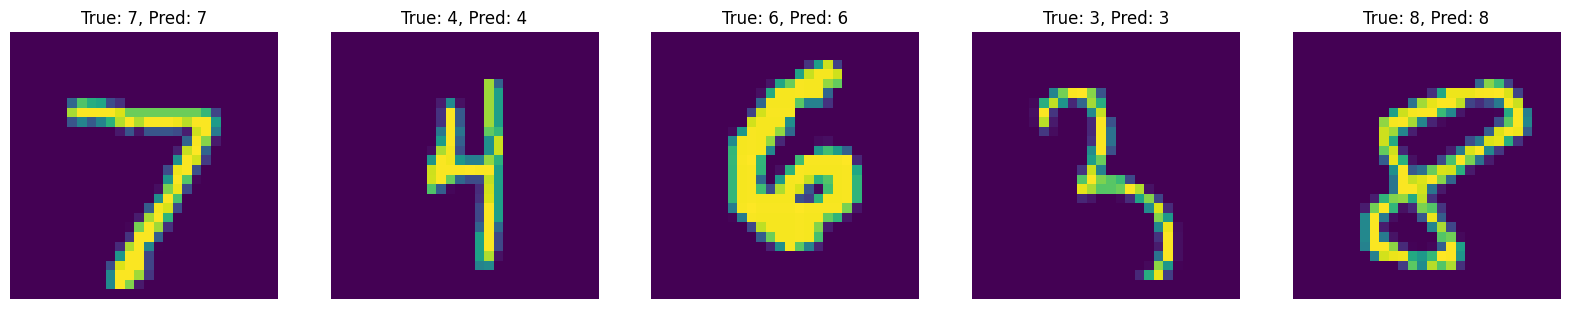

Test Loss: 0.0717


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Display 5 images
    for idx, test_data in enumerate(test_loader):
        data, target = test_data["image"].to(device), test_data["label"].to(device)
        output = model(data)
        test_loss += criterion(output, target).item()

        # Get predictions
        _, pred = output.max(1)

        # Visualize only the first 5 samples
        if idx < 5:
            img = data[idx].cpu().numpy()
            print(f"image {img.shape}")
            img = np.transpose(img, (1, 2, 0))  # Reorder dimensions for visualization

            axes[idx].imshow(img)
            axes[idx].set_title(f"True: {target[idx].item()}, Pred: {pred[idx].item()}")
            axes[idx].axis('off')

    plt.show()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/research/lr_1e-3_epoch_20_128_8_8.pth')


Mounted at /content/drive
